<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/6Sates_clusteringCountyData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=4b7d0715a297ad2bd8a0295911429eed907fbb8f0e486c64efb9d24df3be18c9
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [3]:
import pandas as pd
import wget 
from PIL import Image

from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import os
from pandas import Series, datetime
from pandas.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBClassifier
from sklearn.mixture import GaussianMixture

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load USA State Fips Code

In [ ]:
state_fips_code = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/US_State_FIPSCodes.csv',low_memory=False)
state_fips_code.head()

,State,Postal Code,STFIPS
0,Alabama,AL,1
1,Alaska,AK,2
2,Arizona,AZ,4
3,Arkansas,AR,5
4,California,CA,6


# Load Social Distancing Inertia Data [Maryland University]

In [ ]:
maryland_sd_inertia = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/Maryland_Inertia_Data/County_Oct13.csv',low_memory=False)
maryland_sd_inertia.head()

,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Imported COVID cases,COVID exposure/1000 people,#days: decreasing ILI cases,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,COVID death rate
0,1001,Autauga County,1,54,27,2.25,38.8,1.2,24.7,0.25,2.00,0,55601,-22.5,1/1/2020,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0
1,1001,Autauga County,1,25,18,2.83,43.5,0.9,37.6,0.62,2.21,0,55601,-14.3,1/2/2020,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0
2,1001,Autauga County,1,15,15,3.18,42.2,1.0,40.3,0.62,2.57,0,55601,-0.4,1/3/2020,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0
3,1001,Autauga County,1,33,20,2.85,43.9,1.2,29.5,0.33,2.52,0,55601,-2.3,1/4/2020,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0
4,1001,Autauga County,1,40,22,2.56,42.8,1.2,30.9,0.23,2.33,0,55601,-9.7,1/5/2020,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0


In [ ]:
maryland_sd_inertia['STFIPS'].unique()

array([ 1,  2,  4,  5,  6,  8,  9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56])

## Fixdate column of Social Distancing inertia

In [ ]:
def fixDate(x, appendTwenty):
  arr = x.split('/')
  m = arr[0]
  d = arr[1]
  y = arr[2]

  if int(m) < 10:
    m = '0'+str(m)
  if int(d) < 10:
    d = '0'+str(d)
  if appendTwenty == True:
    return '20'+y+'-'+m+'-'+d
  else:
      return y+'-'+m+'-'+d

In [ ]:
maryland_sd_inertia['date'] = maryland_sd_inertia['date'].apply(lambda x: fixDate(x,False))
maryland_sd_inertia.reset_index(drop=True)

,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Imported COVID cases,COVID exposure/1000 people,#days: decreasing ILI cases,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,COVID death rate
0,1001,Autauga County,1,54,27,2.25,38.8,1.2,24.7,0.25,2.00,0,55601,-22.5,2020-01-01,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0000,0.00,0,47.100000,0.0,0.00,0.00,0,0,0.00,0,0.9,2.7,3.2,0.30,0.00
1,1001,Autauga County,1,25,18,2.83,43.5,0.9,37.6,0.62,2.21,0,55601,-14.3,2020-01-02,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0000,0.00,0,47.100000,0.0,0.00,0.00,0,0,0.00,0,0.9,2.7,3.2,0.30,0.00
2,1001,Autauga County,1,15,15,3.18,42.2,1.0,40.3,0.62,2.57,0,55601,-0.4,2020-01-03,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0000,0.00,0,47.100000,0.0,0.00,0.00,0,0,0.00,0,0.9,2.7,3.2,0.30,0.00
3,1001,Autauga County,1,33,20,2.85,43.9,1.2,29.5,0.33,2.52,0,55601,-2.3,2020-01-04,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0000,0.00,0,47.100000,0.0,0.00,0.00,0,0,0.00,0,0.9,2.7,3.2,0.30,0.00
4,1001,Autauga County,1,40,22,2.56,42.8,1.2,30.9,0.23,2.33,0,55601,-9.7,2020-01-05,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0000,0.00,0,47.100000,0.0,0.00,0.00,0,0,0.00,0,0.9,2.7,3.2,0.30,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901749,56045,Weston County,56,40,20,3.00,27.4,10.3,172.4,0.04,2.96,3,6967,-16.3,2020-10-09,8.34,30,52867,0.5,1.5,53.07,3,1,153,3.76,0.50,0.017,0.3828,5.50,0,38.319241,6.6,191.28,1.32,3,29,9.69,0,1.2,9.3,18.5,1.51,0.96
901750,56045,Weston County,56,37,22,3.37,26.1,10.3,90.4,0.11,3.26,4,6967,-7.8,2020-10-10,8.34,30,52867,0.5,1.5,53.07,3,1,153,3.76,0.50,0.017,0.3828,5.65,0,38.321286,6.7,191.49,1.33,3,29,9.69,0,1.2,9.3,18.5,1.51,0.96
901751,56045,Weston County,56,42,26,2.70,24.5,13.1,71.9,0.06,2.64,0,6967,-25.3,2020-10-11,8.34,30,52867,0.5,1.5,53.07,3,1,153,3.76,0.50,0.017,0.3349,5.81,0,38.323483,6.9,191.76,1.33,3,25,9.69,0,1.2,9.3,18.5,1.51,0.96
901752,56045,Weston County,56,26,19,3.05,25.3,9.9,102.7,0.04,3.00,0,6967,-15.2,2020-10-12,8.34,30,52867,0.5,1.5,53.07,3,1,153,3.76,0.50,0.017,0.1914,6.08,0,38.324928,7.0,192.09,1.33,3,24,9.69,0,1.2,9.3,18.5,1.51,0.96


In [ ]:
maryland_sd_inertia.head(3)

,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Imported COVID cases,COVID exposure/1000 people,#days: decreasing ILI cases,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,COVID death rate
0,1001,Autauga County,1,54,27,2.25,38.8,1.2,24.7,0.25,2.00,0,55601,-22.5,2020-01-01,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0
1,1001,Autauga County,1,25,18,2.83,43.5,0.9,37.6,0.62,2.21,0,55601,-14.3,2020-01-02,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0
2,1001,Autauga County,1,15,15,3.18,42.2,1.0,40.3,0.62,2.57,0,55601,-0.4,2020-01-03,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0


In [ ]:
maryland_sd_inertia.columns

Index(['CTFIPS', 'CTNAME', 'STFIPS', 'Social distancing index',
       '% staying home', 'Trips/person', '% out-of-county trips',
       '% out-of-state trips', 'Miles/person', 'Work trips/person',
       'Non-work trips/person', 'New COVID cases', 'Population',
       '% change in consumption', 'date', 'Transit mode share',
       '% people older than 60', 'Median income', '% African Americans',
       '% Hispanic Americans', '% Male', 'Population density',
       'Employment density', '# hot spots/1000 people',
       'Hospital beds/1000 people', 'ICUs/1000 people',
       '# contact tracing workers/1000 people', 'New cases/1000 people',
       'Active cases/1000 people', '#days: decreasing COVID cases',
       '% hospital bed utilization', 'Testing capacity',
       'Tests done/1000 people', '% ICU utilization', 'Ventilator shortage',
       'Imported COVID cases', 'COVID exposure/1000 people',
       '#days: decreasing ILI cases', 'Unemployment claims/1000 people',
       'Unemploy

## Assign State Name

California, New York, Texas, Iowa, Wisconsin, Colorado

In [ ]:
maryland_sd_inertia = pd.merge(state_fips_code,maryland_sd_inertia,how='inner',left_on=['STFIPS'],right_on=['STFIPS'])
print(maryland_sd_inertia.shape)

maryland_sd_inertia.head(2)

(901467, 45)


,State,Postal Code,STFIPS,CTFIPS,CTNAME,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Imported COVID cases,COVID exposure/1000 people,#days: decreasing ILI cases,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,COVID death rate
0,Alabama,AL,1,1001,Autauga County,54,27,2.25,38.8,1.2,24.7,0.25,2.00,0,55601,-22.5,2020-01-01,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0
1,Alabama,AL,1,1001,Autauga County,25,18,2.83,43.5,0.9,37.6,0.62,2.21,0,55601,-14.3,2020-01-02,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0


In [ ]:
## not using this
def assignStateName(x):
  if x == 6:
    return 'California' # 6
  elif x == 36:
    return 'New York' # 36
  elif x == 48:
    return 'Texas' #1
  elif x == 19:
    return 'Iowa' #19
  elif x == 8:
    return 'Colorado' #8
  elif x == 55:
    return 'Wisconsin' #31
  else:
    return 'NA'

## Filter Data for 6 States

In [ ]:
state_list = ['California', 'New York', 'Texas', 'Iowa', 'Wisconsin', 'Colorado']

maryland_sd_inertia_6states = maryland_sd_inertia[maryland_sd_inertia['State'].isin(state_list)]
print(maryland_sd_inertia_6states.head(3) )

            State Postal Code  ...  Cumulative inflation rate  COVID death rate
53382  California          CA  ...                        0.3               0.0
53383  California          CA  ...                        0.3               0.0
53384  California          CA  ...                        0.3               0.0

[3 rows x 45 columns]


In [ ]:
maryland_sd_inertia_6states.State.unique()

array(['California', 'Colorado', 'Iowa', 'New York', 'Texas', 'Wisconsin'],
      dtype=object)

## Multiclass Classification without a Classifier!

In [ ]:
maryland_sd_inertia_6states.columns

Index(['State', 'Postal Code', 'STFIPS', 'CTFIPS', 'CTNAME',
       'Social distancing index', '% staying home', 'Trips/person',
       '% out-of-county trips', '% out-of-state trips', 'Miles/person',
       'Work trips/person', 'Non-work trips/person', 'New COVID cases',
       'Population', '% change in consumption', 'date', 'Transit mode share',
       '% people older than 60', 'Median income', '% African Americans',
       '% Hispanic Americans', '% Male', 'Population density',
       'Employment density', '# hot spots/1000 people',
       'Hospital beds/1000 people', 'ICUs/1000 people',
       '# contact tracing workers/1000 people', 'New cases/1000 people',
       'Active cases/1000 people', '#days: decreasing COVID cases',
       '% hospital bed utilization', 'Testing capacity',
       'Tests done/1000 people', '% ICU utilization', 'Ventilator shortage',
       'Imported COVID cases', 'COVID exposure/1000 people',
       '#days: decreasing ILI cases', 'Unemployment claims/1000 p

In [ ]:
X_cols = ['Social distancing index','% staying home', 'Trips/person', '% out-of-county trips',
       '% out-of-state trips', 'Miles/person', 'Work trips/person',
       'Non-work trips/person','% change in consumption','Transit mode share',
       '% people older than 60', 'Median income', '% African Americans',
       '% Hispanic Americans', '% Male', 'Population density',
       'Employment density', '# hot spots/1000 people',
       'Hospital beds/1000 people', 'ICUs/1000 people',
       '# contact tracing workers/1000 people','% hospital bed utilization', 'Testing capacity',
       'Tests done/1000 people', '% ICU utilization', 'Ventilator shortage',
       'Imported COVID cases', 'COVID exposure/1000 people',
       '#days: decreasing ILI cases', 'Unemployment claims/1000 people',
       'Unemployment rate', '% working from home', 'Cumulative inflation rate']

Y_col = ['New cases/1000 people']


In [ ]:
# have to check which values are NA
maryland_sd_inertia_6states_filtered = maryland_sd_inertia_6states.dropna()

In [ ]:
n_classes = 3
training_inputs = maryland_sd_inertia_6states_filtered[X_cols].values
#training_outputs_labels = [c for row in maryland_sd_inertia_6states[Y_col].values for c in row]


# K-means clustering

In [ ]:
from sklearn.cluster import KMeans


y_kmeans = KMeans(n_clusters=7,init ='k-means++', max_iter=300, n_init=10,random_state=0 ).fit_predict(training_inputs)

X = training_inputs

In [ ]:
#6 Visualising the clusters
plt.scatter(X[y_kmeans==0, 0], X[y_kmeans==0, 1], s=30, c='red', label ='Cluster 1')
plt.scatter(X[y_kmeans==1, 0], X[y_kmeans==1, 1], s=30, c='blue', label ='Cluster 2')
plt.scatter(X[y_kmeans==2, 0], X[y_kmeans==2, 1], s=30, c='green', label ='Cluster 3')
plt.scatter(X[y_kmeans==3, 0], X[y_kmeans==3, 1], s=30, c='cyan', label ='Cluster 4')
plt.scatter(X[y_kmeans==4, 0], X[y_kmeans==4, 1], s=30, c='magenta', label ='Cluster 5')
plt.scatter(X[y_kmeans==5, 0], X[y_kmeans==5, 1], s=30, c='lightblue', label ='Cluster 6')
plt.scatter(X[y_kmeans==6, 0], X[y_kmeans==6, 1], s=30, c='yellow', label ='Cluster 7')

In [ ]:
y_kmeans

# GMM Clustering

In [ ]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=7)
gmm.fit(training_inputs)

In [ ]:
#predictions from gmm
labels = gmm.predict(training_inputs)
frame = pd.DataFrame(training_inputs)
frame['cluster'] = labels
frame_columns = ['Social distancing index','% staying home', 'Trips/person', '% out-of-county trips',
       '% out-of-state trips', 'Miles/person', 'Work trips/person',
       'Non-work trips/person','% change in consumption','Transit mode share',
       '% people older than 60', 'Median income', '% African Americans',
       '% Hispanic Americans', '% Male', 'Population density',
       'Employment density', '# hot spots/1000 people',
       'Hospital beds/1000 people', 'ICUs/1000 people',
       '# contact tracing workers/1000 people','% hospital bed utilization', 'Testing capacity',
       'Tests done/1000 people', '% ICU utilization', 'Ventilator shortage',
       'Imported COVID cases', 'COVID exposure/1000 people',
       '#days: decreasing ILI cases', 'Unemployment claims/1000 people',
       'Unemployment rate', '% working from home', 'Cumulative inflation rate','cluster']

frame.columns = frame_columns 


In [ ]:

color=['blue','green','cyan', 'yellow','red','lightblue','magenta']
for k in range(0,6):
    data = frame[frame["cluster"]==k]
    plt.scatter(data["Social distancing index"],data["% staying home"],c=color[k])
plt.show()

# Optics Clustering

Commenting code as it is taking lots of time

In [ ]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from matplotlib import gridspec 

# Building the OPTICS Clustering model 
optics_model = OPTICS(min_samples = 30, xi = 0.8, min_cluster_size = 0.08)



In [ ]:
'''
# Training the model 
y_optics = optics_model.fit(training_inputs) 
print('number of hierarchical clusters',len(optics_model.cluster_hierarchy_)-1)

X = training_inputs
'''

In [ ]:
'''
#6 Visualising the clusters
plt.scatter(X[y_optics==0, 0], X[y_optics==0, 1], s=100, c='red', label ='Cluster 1')
plt.scatter(X[y_optics==1, 0], X[y_optics==1, 1], s=100, c='blue', label ='Cluster 2')
plt.scatter(X[y_optics==2, 0], X[y_optics==2, 1], s=100, c='green', label ='Cluster 3')
plt.scatter(X[y_optics==3, 0], X[y_optics==3, 1], s=100, c='cyan', label ='Cluster 4')
plt.scatter(X[y_optics==4, 0], X[y_optics==4, 1], s=100, c='magenta', label ='Cluster 5')
'''

# Sprectal clustering
Comenting the code as it is crashing

In [ ]:
from sklearn.cluster import SpectralClustering

'''
y_sprectal = SpectralClustering(n_clusters=5 ).fit_predict(training_inputs)

X = training_inputs
'''

In [ ]:
'''
#6 Visualising the clusters
plt.scatter(X[y_sprectal==0, 0], X[y_sprectal==0, 1], s=100, c='red', label ='Cluster 1')
plt.scatter(X[y_sprectal==1, 0], X[y_sprectal==1, 1], s=100, c='blue', label ='Cluster 2')
plt.scatter(X[y_sprectal==2, 0], X[y_sprectal==2, 1], s=100, c='green', label ='Cluster 3')
plt.scatter(X[y_sprectal==3, 0], X[y_sprectal==3, 1], s=100, c='cyan', label ='Cluster 4')
plt.scatter(X[y_sprectal==4, 0], X[y_sprectal==4, 1], s=100, c='magenta', label ='Cluster 5')
'''

In [ ]:
#y_sprectal

# AgglomerativeClustering

In [ ]:

import time as time
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.cluster import AgglomerativeClustering


In [ ]:
13976*2

27952

In [ ]:
X = training_inputs[:27952,:]
X.shape

(27952, 33)

In [ ]:
print("Compute unstructured hierarchical clustering...")
st = time.time()
ward = AgglomerativeClustering(n_clusters=5, linkage='ward').fit(X)
elapsed_time = time.time() - st
label = ward.labels_
print("Elapsed time: %.2fs" % elapsed_time)
print("Number of points: %i" % label.size)

Compute unstructured hierarchical clustering...
Elapsed time: 33.21s
Number of points: 27952


Text(0.5, 0.92, 'Without connectivity constraints (time 33.21s)')

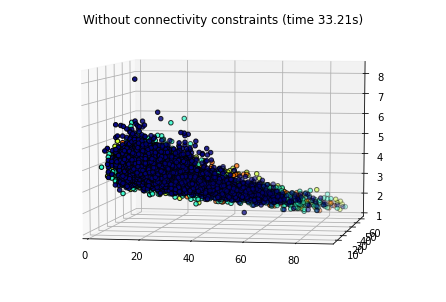

In [ ]:
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(7, -80)
for l in np.unique(label):
    ax.scatter(X[label == l, 0], X[label == l, 1], X[label == l, 2],
               color=plt.cm.jet(np.float(l) / np.max(label + 1)),
               s=20, edgecolor='k')
plt.title('Without connectivity constraints (time %.2fs)' % elapsed_time)

In [ ]:
# Define the structure A of the data. Here a 10 nearest neighbors
from sklearn.neighbors import kneighbors_graph
connectivity = kneighbors_graph(X, n_neighbors=100, include_self=False)

# #############################################################################
# Compute clustering
print("Compute structured hierarchical clustering...")
st = time.time()
ward = AgglomerativeClustering(n_clusters=6, connectivity=connectivity,
                               linkage='ward').fit(X)
elapsed_time = time.time() - st
label = ward.labels_
print("Elapsed time: %.2fs" % elapsed_time)
print("Number of points: %i" % label.size)

Compute structured hierarchical clustering...


/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_agglomerative.py:245: UserWarning: the number of connected components of the connectivity matrix is 49 > 1. Completing it to avoid stopping the tree early.
  affinity='euclidean')


Elapsed time: 31.34s
Number of points: 27952


In [ ]:
label

array([2, 2, 2, ..., 2, 2, 2])

In [ ]:
print(len(X[label == l, 0]))
print(len(X[label == 2, 1]))
print(len(X[label == 3, 2]))
print(len(X[label == 4, 0]))

2009
10445
6314
3444


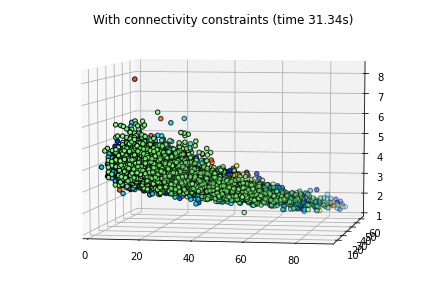

In [ ]:
# Plot result
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(7, -80)
for l in np.unique(label):
    ax.scatter(X[label == l, 0], X[label == l, 1], X[label == l, 2],
               color=plt.cm.jet(float(l) / np.max(label + 1)),
               s=20, edgecolor='k')
plt.title('With connectivity constraints (time %.2fs)' % elapsed_time)

plt.show()

# K-means Cosine create,visualize

ref: https://towardsdatascience.com/cluster-analysis-create-visualize-and-interpret-customer-segments-474e55d00ebb

In [ ]:
X = training_inputs

In [ ]:
X.shape

(139769, 33)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


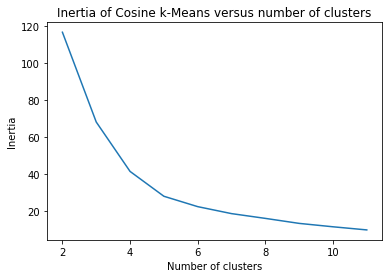

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing

normalized_vectors = preprocessing.normalize(X)
scores = [KMeans(n_clusters=i+2).fit(normalized_vectors).inertia_  
          for i in range(10)]
sns.lineplot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of Cosine k-Means versus number of clusters")
plt.savefig("intertia_cosine_kmeans.jpg", dpi=300)

## silhouette score

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

# Prepare models
kmeans = KMeans(n_clusters=5).fit(X)
# Print results
print('kmeans: {}'.format(silhouette_score(X, kmeans.labels_, 
                                           metric='euclidean')))




kmeans: 0.502287553486621


In [ ]:
normalized_vectors = preprocessing.normalize(X)
normalized_kmeans = KMeans(n_clusters=5).fit(normalized_vectors)

print('Cosine kmeans:{}'.format(silhouette_score(normalized_vectors,
                                          normalized_kmeans.labels_,
                                          metric='cosine')))


Cosine kmeans:0.8539456985964671


In [ ]:
print(min_samples)
print(X.shape)
dbscan.labels_

34
(139769, 33)


array([-1, -1, -1, ..., -1, -1, -1])

In [ ]:

# Data handling
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

# Dimensionality reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Visualization
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import animation

%matplotlib inline 

def load_preprocess_data():
    """ Load and preprocess data
    """
    
    # Load data
    df = pd.read_csv("data.csv")
    
    # remove empty values
    df = df.loc[df.TotalCharges!=" ", :]
    df.TotalCharges = df.TotalCharges.astype(float)
    
    # Label data correctly
    replace_cols = [ 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                    'TechSupport','StreamingTV', 'StreamingMovies', 'Partner', 'Dependents',
                   'PhoneService', 'MultipleLines', 'PaperlessBilling', 'Churn']
    for i in replace_cols : 
        df.loc[:, i]  = df.loc[:, i].replace({'No internet service' : 'No', 'No phone service':'No'})
        df.loc[:, i]  = df.loc[:, i].map({'No':0, 'Yes':1})
    df.gender = df.gender.map({"Female":0, "Male":1})
    
    # One-hot encoding of variables
    others_categorical = ['Contract', 'PaymentMethod', 'InternetService']
    for i in others_categorical:
        df = df.join(pd.get_dummies(df[i], prefix=i))
    df.drop(others_categorical, axis=1, inplace=True)
    
    # Calculate number of services
    services = ['PhoneService', 'MultipleLines', 'OnlineSecurity',
            'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
            'StreamingMovies', 'InternetService_DSL', 'InternetService_Fiber optic',
            'InternetService_No']
    df['nr_services'] = df.apply(lambda row: sum([row[x] for x in services[:-1]]), 1)
    
    return df.drop('customerID', 1)

def plot_corr(df):
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
def plot_tsne(tnse_data, kmeans_labels):
    df_tsne = pd.DataFrame(tsne_data).rename({0: 'x', 1: 'y'}, axis=1)
    df_tsne['z'] = kmeans_labels
    sns.scatterplot(x=df_tsne.x, y=df_tsne.y, hue=df_tsne.z, palette="Set2")
    plt.show()
    
def prepare_pca(n_components, data, kmeans_labels):
    names = ['x', 'y', 'z']
    matrix = PCA(n_components=n_components).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df_matrix['labels'] = kmeans_labels
    
    return df_matrix

def prepare_tsne(n_components, data, kmeans_labels):
    names = ['x', 'y', 'z']
    matrix = TSNE(n_components=n_components).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df_matrix['labels'] = kmeans_labels
    
    return df_matrix

def plot_3d(df, name='labels'):
    iris = px.data.iris()
    fig = px.scatter_3d(df, x='x', y='y', z='z',
                  color=name, opacity=0.5)
    

    fig.update_traces(marker=dict(size=3))
    fig.show()
    
def plot_animation(df, label_column, name):
    def update(num):
        ax.view_init(200, num)

    N=360
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(tsne_3d_df['x'], tsne_3d_df['y'], tsne_3d_df['z'], c=tsne_3d_df[label_column],
               s=6, depthshade=True, cmap='Paired')
    ax.set_zlim(-15, 25)
    ax.set_xlim(-20, 20)
    plt.tight_layout()
    ani = animation.FuncAnimation(fig, update, N, blit=False, interval=50)
    ani.save('{}.gif'.format(name), writer='imagemagick')
    plt.show()

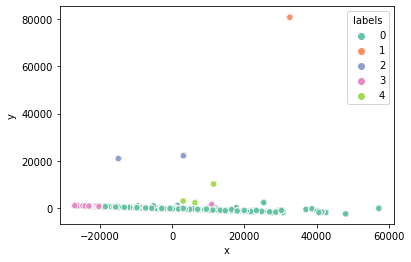

In [ ]:
pca_df = prepare_pca(2, X, normalized_kmeans.labels_)
sns.scatterplot(x=pca_df.x, y=pca_df.y, hue=pca_df.labels, 
                palette="Set2")

In [ ]:
for label in pca_df.labels.unique():
  print("label", label, "  shape",pca_df[pca_df.labels == label].shape)

label 0   shape (116731, 3)
label 3   shape (21589, 3)
label 2   shape (574, 3)
label 1   shape (287, 3)
label 4   shape (588, 3)


In [ ]:

print(X.shape)
maryland_sd_inertia_6states_filtered.shape

(139769, 33)


(139769, 45)

In [ ]:
maryland_sd_inertia_6states_filtered['cluster_label'] = pca_df.labels.to_list()
maryland_sd_inertia_6states_filtered.head(2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,State,Postal Code,STFIPS,CTFIPS,CTNAME,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Imported COVID cases,COVID exposure/1000 people,#days: decreasing ILI cases,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,COVID death rate,cluster_label
226156,Iowa,IA,19,19001,Adair County,51,31,2.39,59.9,15.9,44.7,0.21,2.18,0,7063,-26.9,2020-01-01,0.34,31,51859,0.4,1.9,49.35,12,5,169,3.69,0.26,0.011,0.0,0.0,0,30.0,0.0,0.0,0.0,0,0,0.0,0,1.6,2.8,4.8,0.2,0.0,0
226157,Iowa,IA,19,19001,Adair County,15,18,3.68,55.5,12.0,72.5,0.37,3.31,0,7063,11.0,2020-01-02,0.34,31,51859,0.4,1.9,49.35,12,5,169,3.69,0.26,0.011,0.0,0.0,0,30.0,0.0,0.0,0.0,0,0,0.0,0,1.6,2.8,4.8,0.2,0.0,0


In [ ]:
from datetime import datetime
location = '/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/Maryland_Inertia_Data/'
filename = 'Maryland_inertia_clusterlabeled_'+datetime.now().strftime("%b%d")+'.csv' #%Y%m%d
print(filename)
maryland_sd_inertia_6states_filtered.to_csv(location+filename,index=False)

Maryland_inertia_clusterlabeled_Oct20.csv


# Cluster Result Analysis

In [4]:
maryland_sd_inertia_6states_filtered = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/Maryland_Inertia_Data/Maryland_inertia_clusterlabeled_Oct20.csv',low_memory=False)
maryland_sd_inertia_6states_filtered.head(2)

,State,Postal Code,STFIPS,CTFIPS,CTNAME,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Imported COVID cases,COVID exposure/1000 people,#days: decreasing ILI cases,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,COVID death rate,cluster_label
0,Iowa,IA,19,19001,Adair County,51,31,2.39,59.9,15.9,44.7,0.21,2.18,0,7063,-26.9,2020-01-01,0.34,31,51859,0.4,1.9,49.35,12,5,169,3.69,0.26,0.011,0.0,0.0,0,30.0,0.0,0.0,0.0,0,0,0.0,0,1.6,2.8,4.8,0.2,0.0,0
1,Iowa,IA,19,19001,Adair County,15,18,3.68,55.5,12.0,72.5,0.37,3.31,0,7063,11.0,2020-01-02,0.34,31,51859,0.4,1.9,49.35,12,5,169,3.69,0.26,0.011,0.0,0.0,0,30.0,0.0,0.0,0.0,0,0,0.0,0,1.6,2.8,4.8,0.2,0.0,0


In [ ]:
maryland_sd_inertia_6states_filtered.head(2)

,State,Postal Code,STFIPS,CTFIPS,CTNAME,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Imported COVID cases,COVID exposure/1000 people,#days: decreasing ILI cases,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,COVID death rate,cluster_label
0,Iowa,IA,19,19001,Adair County,51,31,2.39,59.9,15.9,44.7,0.21,2.18,0,7063,-26.9,2020-01-01,0.34,31,51859,0.4,1.9,49.35,12,5,169,3.69,0.26,0.011,0.0,0.0,0,30.0,0.0,0.0,0.0,0,0,0.0,0,1.6,2.8,4.8,0.2,0.0,0
1,Iowa,IA,19,19001,Adair County,15,18,3.68,55.5,12.0,72.5,0.37,3.31,0,7063,11.0,2020-01-02,0.34,31,51859,0.4,1.9,49.35,12,5,169,3.69,0.26,0.011,0.0,0.0,0,30.0,0.0,0.0,0.0,0,0,0.0,0,1.6,2.8,4.8,0.2,0.0,0


## Cluster -1

From analysis: Here one county is forming a cluster. That county is 'New York County'

In [ ]:
maryland_sd_inertia_6states_filtered[maryland_sd_inertia_6states_filtered['cluster_label'] == 1]['New cases/1000 people'].shape

(287,)

In [ ]:
cluster_1= maryland_sd_inertia_6states_filtered[maryland_sd_inertia_6states_filtered['cluster_label'] == 1]
cluster_1.reset_index(drop=True)

,State,Postal Code,STFIPS,CTFIPS,CTNAME,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Imported COVID cases,COVID exposure/1000 people,#days: decreasing ILI cases,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,COVID death rate,cluster_label
0,New York,NY,36,36061,New York County,59,49,2.13,53.3,16.5,36.3,0.30,1.83,0,1628701,-19.9,2020-01-01,59.3,21,82459,12.5,26.0,47.3,48341,67846,311,2.74,0.22,0.029,0.0000,0.00,0,63.500000,0.0,0.00,0.00,0,0,0.00,0,2.3,3.8,4.2,0.7,0.00,1
1,New York,NY,36,36061,New York County,33,39,2.88,60.6,20.0,31.3,0.56,2.32,0,1628701,1.5,2020-01-02,59.3,21,82459,12.5,26.0,47.3,48341,67846,311,2.74,0.22,0.029,0.0000,0.00,0,63.500000,0.0,0.00,0.00,0,0,0.00,0,2.3,3.8,4.2,0.7,0.00,1
2,New York,NY,36,36061,New York County,33,39,2.88,60.4,19.4,32.6,0.55,2.33,0,1628701,1.9,2020-01-03,59.3,21,82459,12.5,26.0,47.3,48341,67846,311,2.74,0.22,0.029,0.0000,0.00,0,63.500000,0.0,0.00,0.00,0,0,0.00,0,2.3,3.8,4.2,0.7,0.00,1
3,New York,NY,36,36061,New York County,50,46,2.62,51.9,14.3,34.0,0.36,2.26,0,1628701,-1.1,2020-01-04,59.3,21,82459,12.5,26.0,47.3,48341,67846,311,2.74,0.22,0.029,0.0000,0.00,0,63.500000,0.0,0.00,0.00,0,0,0.00,0,2.3,3.8,4.2,0.7,0.00,1
4,New York,NY,36,36061,New York County,59,51,2.30,52.6,15.1,34.4,0.34,1.96,0,1628701,-14.3,2020-01-05,59.3,21,82459,12.5,26.0,47.3,48341,67846,311,2.74,0.22,0.029,0.0000,0.00,0,63.500000,0.0,0.00,0.00,0,0,0.00,0,1.2,3.8,4.2,0.7,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,New York,NY,36,36061,New York County,75,55,2.26,54.5,15.6,24.4,0.37,1.89,73,1628701,-17.3,2020-10-09,59.3,21,82459,12.5,26.0,47.3,48341,67846,311,2.74,0.22,0.029,0.0434,1.55,0,64.944676,4.0,603.14,3.91,86,2482,18.08,196,3.4,18.6,22.4,1.3,9.42,1
283,New York,NY,36,36061,New York County,75,54,2.39,49.4,13.9,27.4,0.31,2.08,79,1628701,-9.0,2020-10-10,59.3,21,82459,12.5,26.0,47.3,48341,67846,311,2.74,0.22,0.029,0.0501,1.58,0,64.968286,4.0,610.03,4.16,88,2200,18.08,196,3.4,18.6,22.4,1.3,9.42,1
284,New York,NY,36,36061,New York County,68,59,2.14,49.2,13.7,28.3,0.37,1.76,46,1628701,-23.0,2020-10-11,59.3,21,82459,12.5,26.0,47.3,48341,67846,311,2.74,0.22,0.029,0.0405,1.60,1,64.992948,3.9,616.08,4.32,89,1978,18.08,196,3.4,18.6,22.4,1.3,9.42,1
285,New York,NY,36,36061,New York County,73,62,1.80,56.6,16.2,23.6,0.39,1.41,66,1628701,-38.3,2020-10-12,59.3,21,82459,12.5,26.0,47.3,48341,67846,311,2.74,0.22,0.029,0.0391,1.61,2,65.018630,3.9,620.78,4.30,91,2191,18.08,196,3.4,18.6,22.4,1.3,9.42,1


In [ ]:
cluster_1['New cases/1000 people']

37023    0.0000
37024    0.0000
37025    0.0000
37026    0.0000
37027    0.0000
          ...  
37305    0.0434
37306    0.0501
37307    0.0405
37308    0.0391
37309    0.0420
Name: New cases/1000 people, Length: 287, dtype: float64

In [ ]:
cluster_1.head(2)

,State,Postal Code,STFIPS,CTFIPS,CTNAME,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Imported COVID cases,COVID exposure/1000 people,#days: decreasing ILI cases,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,COVID death rate,cluster_label
37023,New York,NY,36,36061,New York County,59,49,2.13,53.3,16.5,36.3,0.30,1.83,0,1628701,-19.9,2020-01-01,59.3,21,82459,12.5,26.0,47.3,48341,67846,311,2.74,0.22,0.029,0.0,0.0,0,63.5,0.0,0.0,0.0,0,0,0.0,0,2.3,3.8,4.2,0.7,0.0,1
37024,New York,NY,36,36061,New York County,33,39,2.88,60.6,20.0,31.3,0.56,2.32,0,1628701,1.5,2020-01-02,59.3,21,82459,12.5,26.0,47.3,48341,67846,311,2.74,0.22,0.029,0.0,0.0,0,63.5,0.0,0.0,0.0,0,0,0.0,0,2.3,3.8,4.2,0.7,0.0,1


In [ ]:
#states of cluster one

cluster_1.State.unique()


array(['New York'], dtype=object)

In [ ]:
#min max of new cases by group

cluster_1.groupby(['CTNAME']).agg({'New cases/1000 people': ['mean', 'min', 'max']})

New cases/1000 people             
                                 mean  min     max
CTNAME                                            
New York County              0.499947  0.0  3.4561

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


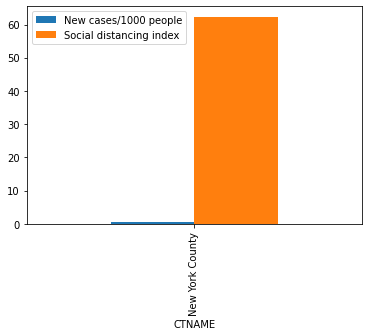

In [ ]:
cluster_1.groupby(["CTNAME"])['New cases/1000 people', 'Social distancing index'].mean().plot(kind='bar')

In [ ]:
## Min value of all column

cluster_1.min(axis=0) # will return min value of each column

State                                           New York
Postal Code                                           NY
STFIPS                                                36
CTFIPS                                             36061
CTNAME                                   New York County
Social distancing index                               28
% staying home                                        36
Trips/person                                        1.29
% out-of-county trips                               38.3
% out-of-state trips                                 6.5
Miles/person                                         7.3
Work trips/person                                   0.23
Non-work trips/person                               1.05
New COVID cases                                        0
Population                                       1628701
% change in consumption                            -54.1
date                                          2020-01-01
Transit mode share             

In [ ]:
## Max value of all column

cluster_1.max(axis=0) # will return max value of each column

State                                           New York
Postal Code                                           NY
STFIPS                                                36
CTFIPS                                             36061
CTNAME                                   New York County
Social distancing index                               89
% staying home                                        75
Trips/person                                        3.27
% out-of-county trips                               63.6
% out-of-state trips                                22.3
Miles/person                                        59.3
Work trips/person                                   0.76
Non-work trips/person                               2.65
New COVID cases                                     7837
Population                                       1628701
% change in consumption                             15.9
date                                          2020-10-13
Transit mode share             

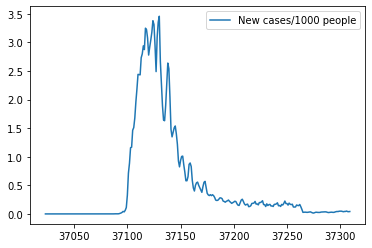

In [ ]:
cluster_1[['date','New cases/1000 people']].plot()

In [ ]:
cluster_1['date'].unique()

array(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
       '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
       '2020-01-09', '2020-01-10', '2020-01-11', '2020-01-12',
       '2020-01-13', '2020-01-14', '2020-01-15', '2020-01-16',
       '2020-01-17', '2020-01-18', '2020-01-19', '2020-01-20',
       '2020-01-21', '2020-01-22', '2020-01-23', '2020-01-24',
       '2020-01-25', '2020-01-26', '2020-01-27', '2020-01-28',
       '2020-01-29', '2020-01-30', '2020-01-31', '2020-02-01',
       '2020-02-02', '2020-02-03', '2020-02-04', '2020-02-05',
       '2020-02-06', '2020-02-07', '2020-02-08', '2020-02-09',
       '2020-02-10', '2020-02-11', '2020-02-12', '2020-02-13',
       '2020-02-14', '2020-02-15', '2020-02-16', '2020-02-17',
       '2020-02-18', '2020-02-19', '2020-02-20', '2020-02-21',
       '2020-02-22', '2020-02-23', '2020-02-24', '2020-02-25',
       '2020-02-26', '2020-02-27', '2020-02-28', '2020-02-29',
       '2020-03-01', '2020-03-02', '2020-03-03', '2020-

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 <a list of 13 Text major ticklabel objects>)

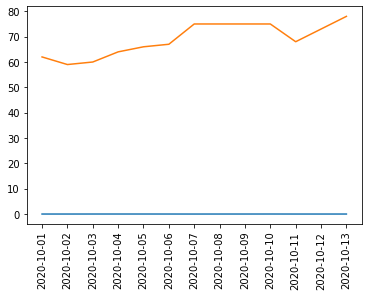

In [ ]:
plt.figure()

date_list = ['2020-10-01', '2020-10-02',
       '2020-10-03', '2020-10-04', '2020-10-05', '2020-10-06',
       '2020-10-07', '2020-10-08', '2020-10-09', '2020-10-10',
       '2020-10-11', '2020-10-12', '2020-10-13']

filter_data = cluster_1[cluster_1['date'].isin(date_list)]
x = filter_data['date']
y1 = filter_data['New cases/1000 people'] 
y2 = filter_data['Social distancing index']


plt.plot(x,y1)
plt.plot(x,y2)
plt.xticks(rotation=90)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


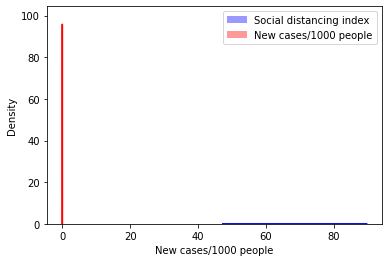

In [ ]:
# Method 1: on the same Axis
date_list = ['2020-10-01', '2020-10-02',
       '2020-10-03', '2020-10-04', '2020-10-05', '2020-10-06',
       '2020-10-07', '2020-10-08', '2020-10-09', '2020-10-10',
       '2020-10-11', '2020-10-12', '2020-10-13']

filter_data = cluster_1[cluster_1['date'].isin(date_list)]

sns.distplot( (filter_data['Social distancing index']) , color="blue", label='Social distancing index')
sns.distplot( filter_data['New cases/1000 people'] , color="red", label='New cases/1000 people')
plt.legend()
 
plt.show()


This code is not working. I was trying to plot this link: https://stackoverflow.com/questions/43382051/how-to-plot-min-max-line-plot-in-python-pandas


data = cluster_1.groupby('date')['New cases/1000 people'].agg({'Low Value':'min','High Value':'max','Mean':'mean'})
data.reset_index(inplace=True)

ax  = data.plot(x='date', y='Mean', c='white')
plt.fill_between(x='date',y1='Low Value',y2='High Value', data=data)

## Cluster -4



### Different Analysis

In [9]:
maryland_sd_inertia_6states_filtered[maryland_sd_inertia_6states_filtered['cluster_label'] == 4]['New cases/1000 people'].shape

(588,)

In [10]:
cluster_4= maryland_sd_inertia_6states_filtered[maryland_sd_inertia_6states_filtered['cluster_label'] == 4]
cluster_4.reset_index(drop=True)

,State,Postal Code,STFIPS,CTFIPS,CTNAME,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Imported COVID cases,COVID exposure/1000 people,#days: decreasing ILI cases,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,COVID death rate,cluster_label
0,New York,NY,36,36081,Queens County,58,41,2.64,39.7,5.1,25.9,0.37,2.27,0,2278906,-24.8,2020-01-01,51.31,21,64987,17.2,28.0,48.49,12893,3300,81,2.74,0.22,0.029,0.0000,0.00,0,63.500000,0.0,0.00,0.00,0,0,0.00,0,2.3,3.8,4.2,0.70,0.00,4
1,New York,NY,36,36081,Queens County,25,27,3.80,40.5,3.2,28.5,0.81,2.98,0,2278906,-1.3,2020-01-02,51.31,21,64987,17.2,28.0,48.49,12893,3300,81,2.74,0.22,0.029,0.0000,0.00,0,63.500000,0.0,0.00,0.00,0,0,0.00,0,2.3,3.8,4.2,0.70,0.00,4
2,New York,NY,36,36081,Queens County,24,27,3.84,40.2,3.3,29.1,0.79,3.05,0,2278906,1.0,2020-01-03,51.31,21,64987,17.2,28.0,48.49,12893,3300,81,2.74,0.22,0.029,0.0000,0.00,0,63.500000,0.0,0.00,0.00,0,0,0.00,0,2.3,3.8,4.2,0.70,0.00,4
3,New York,NY,36,36081,Queens County,44,35,3.41,38.0,3.8,26.7,0.48,2.93,0,2278906,-3.0,2020-01-04,51.31,21,64987,17.2,28.0,48.49,12893,3300,81,2.74,0.22,0.029,0.0000,0.00,0,63.500000,0.0,0.00,0.00,0,0,0.00,0,2.3,3.8,4.2,0.70,0.00,4
4,New York,NY,36,36081,Queens County,53,40,2.99,38.4,4.5,28.4,0.40,2.58,0,2278906,-14.6,2020-01-05,51.31,21,64987,17.2,28.0,48.49,12893,3300,81,2.74,0.22,0.029,0.0000,0.00,0,63.500000,0.0,0.00,0.00,0,0,0.00,0,1.2,3.8,4.2,0.70,0.00,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,Texas,TX,48,48439,Tarrant County,32,27,2.99,22.2,1.7,39.2,0.41,2.59,601,2084931,2.1,2020-10-04,0.58,16,64874,15.8,28.5,48.95,2251,912,133,2.82,0.30,0.040,0.2192,4.93,0,52.081858,11.7,227.79,12.28,1015,5415,21.60,196,1.5,10.1,25.9,0.79,2.63,4
584,Texas,TX,48,48439,Tarrant County,38,22,3.26,21.0,1.2,37.0,0.41,2.85,572,2084931,12.3,2020-10-07,0.58,16,64874,15.8,28.5,48.95,2251,912,133,2.82,0.30,0.040,0.1906,5.13,0,51.777966,11.7,232.20,12.06,729,5653,21.58,196,1.5,10.1,25.9,0.79,2.69,4
585,Texas,TX,48,48439,Tarrant County,39,22,2.97,22.4,1.4,38.7,0.40,2.57,546,2084931,1.3,2020-10-08,0.58,16,64874,15.8,28.5,48.95,2251,912,133,2.82,0.30,0.040,0.2353,5.15,0,51.721974,11.7,233.54,12.59,719,5579,21.51,196,1.5,10.1,25.9,0.79,2.72,4
586,Texas,TX,48,48439,Tarrant County,37,22,2.78,25.2,1.7,44.4,0.39,2.38,314,2084931,-6.2,2020-10-09,0.58,16,64874,15.8,28.5,48.95,2251,912,133,2.82,0.30,0.040,0.2289,5.13,1,51.669449,11.6,235.04,13.04,710,5956,21.44,196,1.5,10.1,25.9,0.79,2.74,4


In [11]:
cluster_4['New cases/1000 people']

39893     0.0000
39894     0.0000
39895     0.0000
39896     0.0000
39897     0.0000
           ...  
109337    0.2192
109340    0.1906
109341    0.2353
109342    0.2289
109343    0.2043
Name: New cases/1000 people, Length: 588, dtype: float64

In [12]:
#states of cluster one

cluster_4.State.unique()


array(['New York', 'Texas'], dtype=object)

In [13]:
#states of cluster one

cluster_4.CTNAME.unique()

array(['Queens County', 'Dallas County', 'Harris County',
       'Tarrant County'], dtype=object)

In [14]:
#min max of new cases by each county of cluster

cluster_4.groupby(['CTNAME']).agg({'New cases/1000 people': ['mean', 'min', 'max']})

New cases/1000 people                
                                mean     min     max
CTNAME                                              
Dallas County               0.237889  0.0315  1.0107
Harris County               0.243668  0.0834  1.0997
Queens County               0.007462  0.0000  0.0740
Tarrant County              0.215992  0.0000  0.5059

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


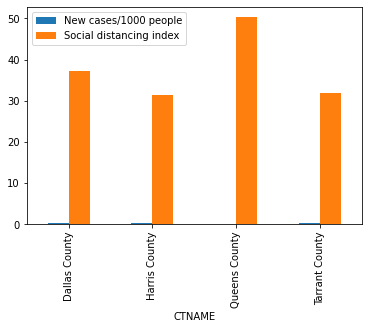

In [15]:
cluster_4.groupby("CTNAME")['New cases/1000 people', 'Social distancing index'].mean().plot(kind='bar')

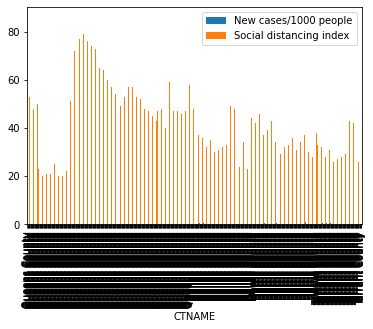

In [16]:
cluster_4.plot(x="CTNAME", y=['New cases/1000 people', 'Social distancing index'], kind="bar")

In [17]:
## Min value of all column

cluster_4.min(axis=0) # will return min value of each column

State                                         New York
Postal Code                                         NY
STFIPS                                              36
CTFIPS                                           36081
CTNAME                                   Dallas County
Social distancing index                             18
% staying home                                      19
Trips/person                                      1.68
% out-of-county trips                             13.8
% out-of-state trips                               0.2
Miles/person                                      10.2
Work trips/person                                 0.16
Non-work trips/person                              1.4
New COVID cases                                      0
Population                                     2084931
% change in consumption                          -53.6
date                                        2020-01-01
Transit mode share                                0.58
% people o

In [18]:
## Max value of all column

cluster_4.max(axis=0) # will return max value of each column

State                                             Texas
Postal Code                                          TX
STFIPS                                               48
CTFIPS                                            48439
CTNAME                                   Tarrant County
Social distancing index                              86
% staying home                                       66
Trips/person                                       4.23
% out-of-county trips                              42.2
% out-of-state trips                                5.1
Miles/person                                       63.9
Work trips/person                                   0.9
Non-work trips/person                              3.58
New COVID cases                                   14129
Population                                      4698619
% change in consumption                            26.9
date                                         2020-10-13
Transit mode share                              

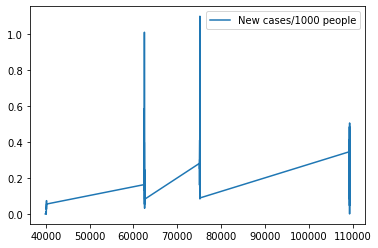

In [19]:
cluster_4[['date','New cases/1000 people']].plot()

In [20]:
cluster_4['date'].unique()

array(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
       '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
       '2020-01-09', '2020-01-10', '2020-01-11', '2020-01-12',
       '2020-01-13', '2020-01-14', '2020-01-15', '2020-01-16',
       '2020-01-17', '2020-01-18', '2020-01-19', '2020-01-20',
       '2020-01-21', '2020-01-22', '2020-01-23', '2020-01-24',
       '2020-01-25', '2020-01-26', '2020-01-27', '2020-01-28',
       '2020-01-29', '2020-01-30', '2020-01-31', '2020-02-01',
       '2020-02-02', '2020-02-03', '2020-02-04', '2020-02-05',
       '2020-02-06', '2020-02-07', '2020-02-08', '2020-02-09',
       '2020-02-10', '2020-02-11', '2020-02-12', '2020-02-13',
       '2020-02-14', '2020-02-15', '2020-02-16', '2020-02-17',
       '2020-02-18', '2020-02-19', '2020-02-20', '2020-02-21',
       '2020-02-22', '2020-02-23', '2020-02-24', '2020-02-25',
       '2020-02-26', '2020-02-27', '2020-02-28', '2020-02-29',
       '2020-03-01', '2020-03-02', '2020-03-03', '2020-

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 <a list of 13 Text major ticklabel objects>)

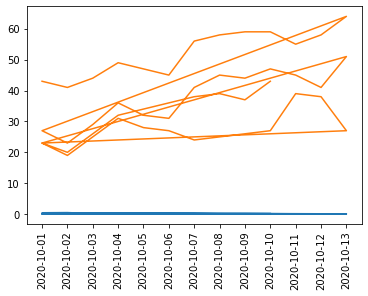

In [21]:
plt.figure()

date_list = ['2020-10-01', '2020-10-02',
       '2020-10-03', '2020-10-04', '2020-10-05', '2020-10-06',
       '2020-10-07', '2020-10-08', '2020-10-09', '2020-10-10',
       '2020-10-11', '2020-10-12', '2020-10-13']

filter_data = cluster_4[cluster_4['date'].isin(date_list)]
x = filter_data['date']
y1 = filter_data['New cases/1000 people'] 
y2 = filter_data['Social distancing index']


plt.plot(x,y1)
plt.plot(x,y2)
plt.xticks(rotation=90)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


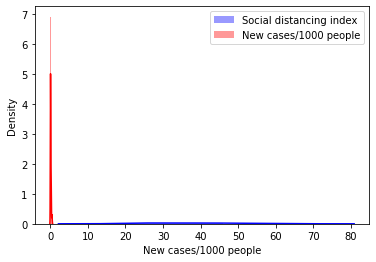

In [22]:
# Method 1: on the same Axis
date_list = ['2020-10-01', '2020-10-02',
       '2020-10-03', '2020-10-04', '2020-10-05', '2020-10-06',
       '2020-10-07', '2020-10-08', '2020-10-09', '2020-10-10',
       '2020-10-11', '2020-10-12', '2020-10-13']

filter_data = cluster_4[cluster_4['date'].isin(date_list)]

sns.distplot( (filter_data['Social distancing index']) , color="blue", label='Social distancing index')
sns.distplot( filter_data['New cases/1000 people'] , color="red", label='New cases/1000 people')
plt.legend()
 
plt.show()

New case for each county

(array([-50.,   0.,  50., 100., 150., 200., 250., 300., 350.]),
 <a list of 9 Text major ticklabel objects>)

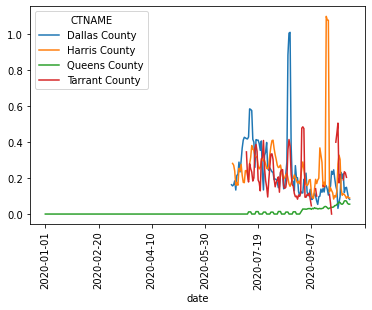

In [23]:
cluster_4.pivot(index='date', columns='CTNAME', values='New cases/1000 people').plot()
plt.xticks(rotation=90)

(array([-2.,  0.,  2.,  4.,  6.,  8., 10., 12., 14.]),
 <a list of 9 Text major ticklabel objects>)

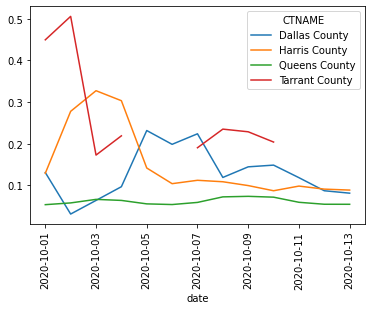

In [24]:
# Method 1: on the same Axis
date_list = ['2020-10-01', '2020-10-02',
       '2020-10-03', '2020-10-04', '2020-10-05', '2020-10-06',
       '2020-10-07', '2020-10-08', '2020-10-09', '2020-10-10',
       '2020-10-11', '2020-10-12', '2020-10-13']

filter_data = cluster_4[cluster_4['date'].isin(date_list)]
filter_data.pivot(index='date', columns='CTNAME', values='New cases/1000 people').plot()
plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 <a list of 13 Text major ticklabel objects>)

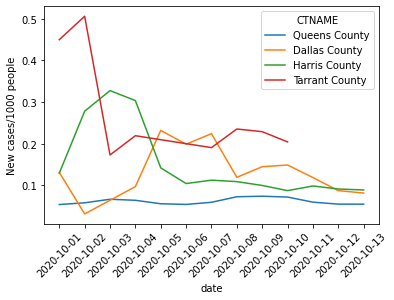

In [25]:
sns.lineplot(data=filter_data, hue='CTNAME', x='date', y='New cases/1000 people')
plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 <a list of 13 Text major ticklabel objects>)

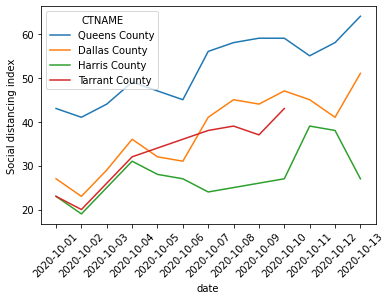

In [26]:
sns.lineplot(data=filter_data, hue='CTNAME', x='date', y='Social distancing index')
plt.xticks(rotation=45)

### Filter

In [41]:
cluster_4.columns

Index(['State', 'Postal Code', 'STFIPS', 'CTFIPS', 'CTNAME',
       'Social distancing index', '% staying home', 'Trips/person',
       '% out-of-county trips', '% out-of-state trips', 'Miles/person',
       'Work trips/person', 'Non-work trips/person', 'New COVID cases',
       'Population', '% change in consumption', 'date', 'Transit mode share',
       '% people older than 60', 'Median income', '% African Americans',
       '% Hispanic Americans', '% Male', 'Population density',
       'Employment density', '# hot spots/1000 people',
       'Hospital beds/1000 people', 'ICUs/1000 people',
       '# contact tracing workers/1000 people', 'New cases/1000 people',
       'Active cases/1000 people', '#days: decreasing COVID cases',
       '% hospital bed utilization', 'Testing capacity',
       'Tests done/1000 people', '% ICU utilization', 'Ventilator shortage',
       'Imported COVID cases', 'COVID exposure/1000 people',
       '#days: decreasing ILI cases', 'Unemployment claims/1000 p

In [44]:
filter_col= ['Social distancing index','% staying home', 'Trips/person', '% out-of-county trips',
       '% out-of-state trips', 'Miles/person', 'Work trips/person',
       'Non-work trips/person','% change in consumption','Transit mode share',
       '% people older than 60', 'Median income', '% African Americans',
       '% Hispanic Americans', '% Male', 'Population density',
       'Employment density', '# hot spots/1000 people',
       'Hospital beds/1000 people', 'ICUs/1000 people',
       '# contact tracing workers/1000 people','% hospital bed utilization', 'Testing capacity',
       'Tests done/1000 people', '% ICU utilization', 'Ventilator shortage',
       'Imported COVID cases', 'COVID exposure/1000 people',
       '#days: decreasing ILI cases', 'Unemployment claims/1000 people',
       'Unemployment rate', '% working from home', 'Cumulative inflation rate','New cases/1000 people']

social_dist= ['Social distancing index','% staying home', 'Trips/person', '% out-of-county trips',
       '% out-of-state trips', 'Miles/person', 'Work trips/person',
       'Non-work trips/person','% change in consumption','Transit mode share',
       '% working from home', 'New cases/1000 people']

demographic = ['% people older than 60', 'Median income', '% African Americans',
       '% Hispanic Americans', '% Male', 'Population density',
       'Employment density','# hot spots/1000 people',
       'Hospital beds/1000 people', 'ICUs/1000 people',
       '# contact tracing workers/1000 people','% hospital bed utilization', 'Testing capacity',
       'Tests done/1000 people', '% ICU utilization', 'Ventilator shortage',
       'Imported COVID cases', 'COVID exposure/1000 people','New cases/1000 people']

employment = ['Unemployment claims/1000 people',
       'Unemployment rate', '% working from home', 'Cumulative inflation rate','New cases/1000 people']

In [38]:
cluster_4_filter = cluster_4[social_dist]

In [30]:
cluster_4_filter.head(2)

,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,% change in consumption,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Imported COVID cases,COVID exposure/1000 people,#days: decreasing ILI cases,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,New cases/1000 people
39893,58,41,2.64,39.7,5.1,25.9,0.37,2.27,-24.8,51.31,21,64987,17.2,28.0,48.49,12893,3300,81,2.74,0.22,0.029,63.5,0.0,0.0,0.0,0,0,0.0,0,2.3,3.8,4.2,0.7,0.0
39894,25,27,3.80,40.5,3.2,28.5,0.81,2.98,-1.3,51.31,21,64987,17.2,28.0,48.49,12893,3300,81,2.74,0.22,0.029,63.5,0.0,0.0,0.0,0,0,0.0,0,2.3,3.8,4.2,0.7,0.0


### Histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2a155c0198>,
      dtype=object)

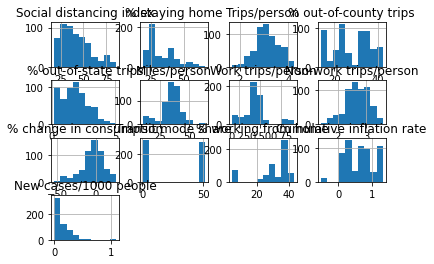

In [39]:
cluster_4[social_dist].hist()

### Correlation Plot

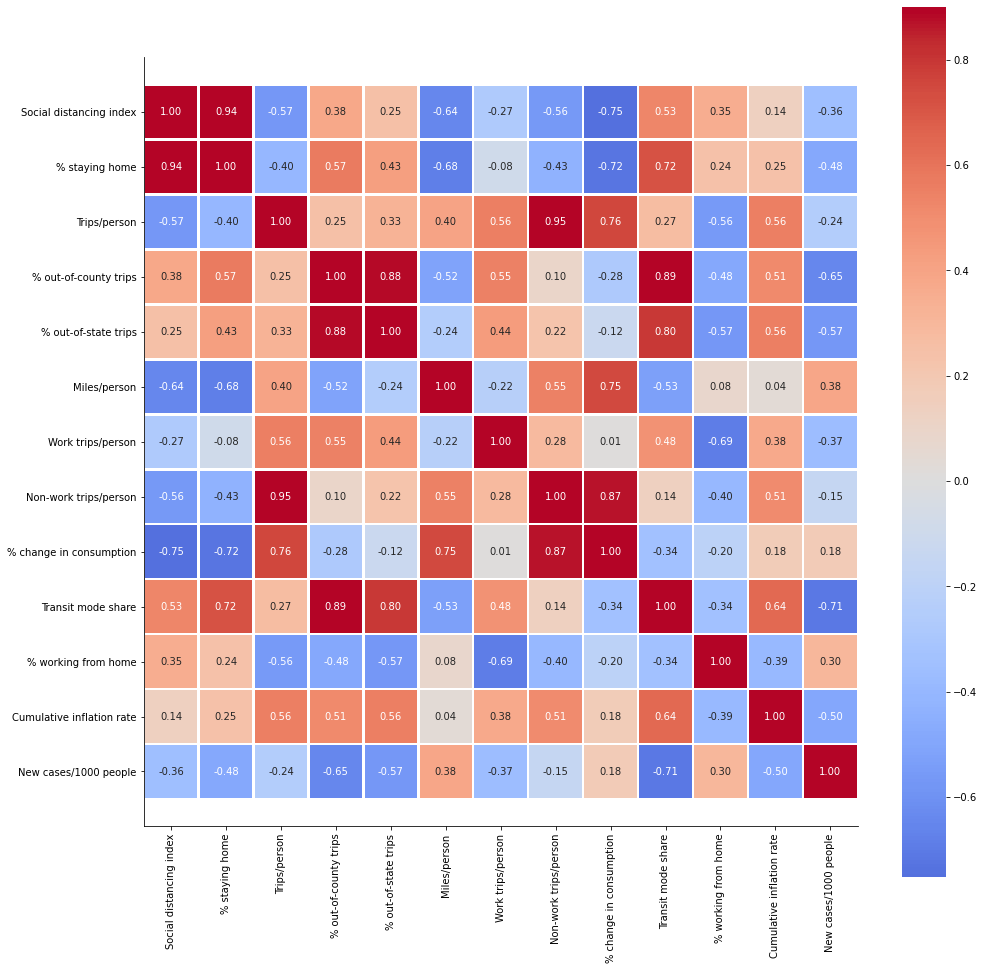

In [40]:
corr = cluster_4[social_dist].corr()
g = sns.heatmap(corr, vmax=.9, center=0,
               square=True, linewidths=1.5, cbar_kws={"shrink": .8}, annot=True, fmt='.2f', cmap='coolwarm')
bottom, top = g.get_ylim()
g.set_ylim(bottom + 0.5, top - 0.5)
sns.despine()
g.figure.set_size_inches(16, 20)

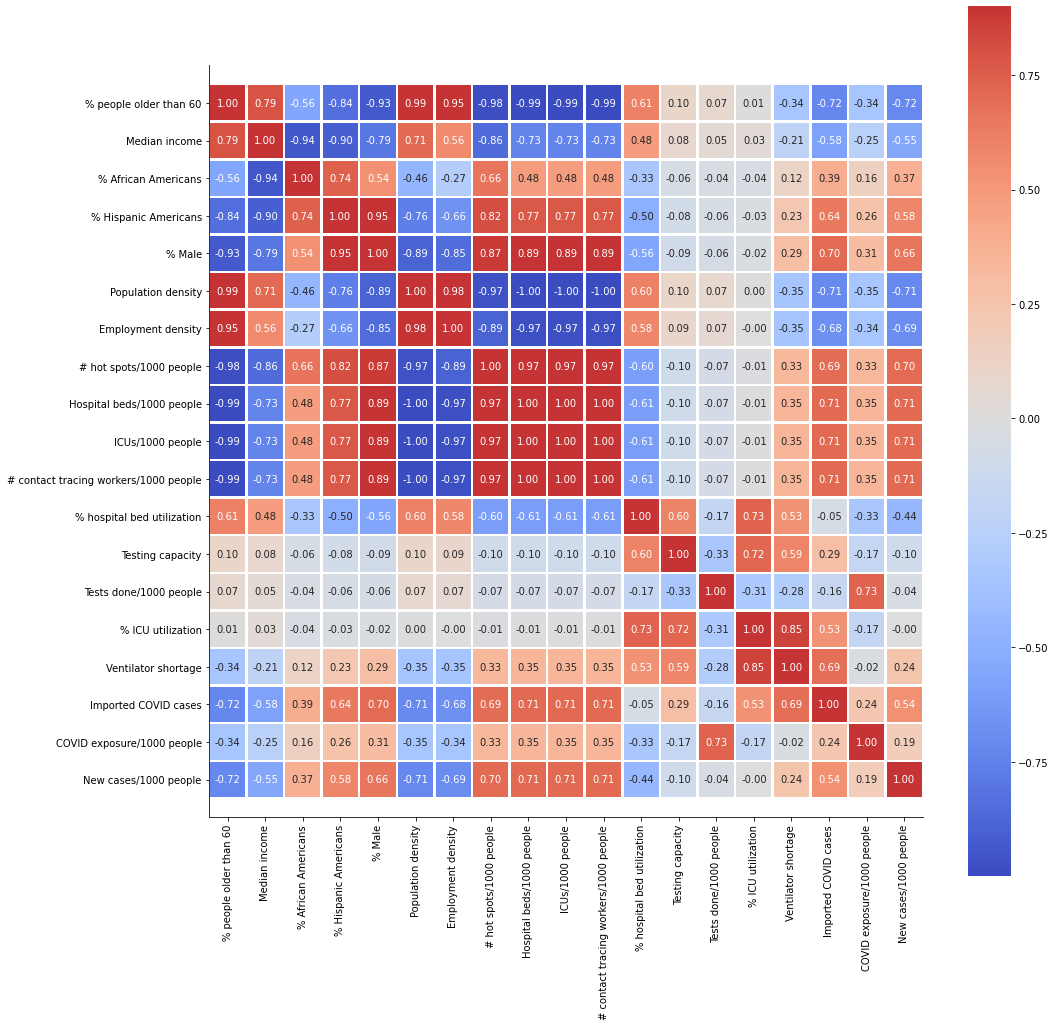

In [43]:
corr = cluster_4[demographic].corr()
g = sns.heatmap(corr, vmax=.9, center=0,
               square=True, linewidths=1.5, cbar_kws={"shrink": .8}, annot=True, fmt='.2f', cmap='coolwarm')
bottom, top = g.get_ylim()
g.set_ylim(bottom + 0.5, top - 0.5)
sns.despine()
g.figure.set_size_inches(16, 20)

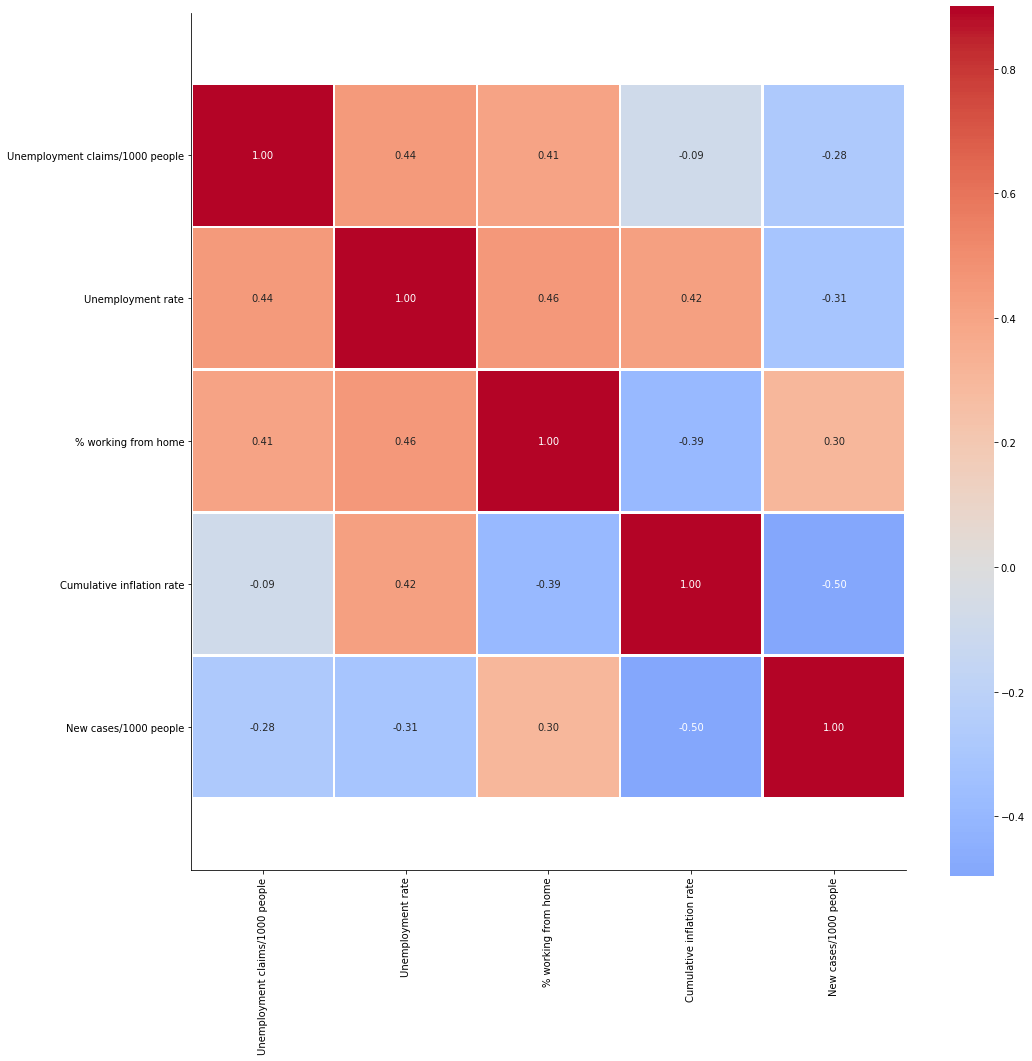

In [45]:
corr = cluster_4[employment].corr()
g = sns.heatmap(corr, vmax=.9, center=0,
               square=True, linewidths=1.5, cbar_kws={"shrink": .8}, annot=True, fmt='.2f', cmap='coolwarm')
bottom, top = g.get_ylim()
g.set_ylim(bottom + 0.5, top - 0.5)
sns.despine()
g.figure.set_size_inches(16, 20)

## tSNE 3D

KeyError: ignored

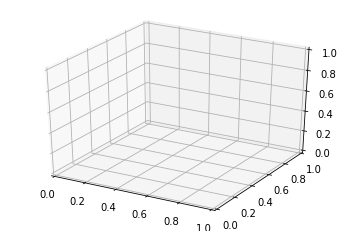

In [ ]:
tsne_3d_df = prepare_tsne(3, X, kmeans.labels_)
plot_animation(tsne_3d_df, 'kmeans', 'kmeans')


In [ ]:
tsne_3d_df['normalized_kmeans'] = normalized_kmeans.labels_
plot_animation(tsne_3d_df, 'normalized_kmeans', 'normalized_kmeans')


In [ ]:
tsne_3d_df['dbscan'] = dbscan.labels_
plot_animation(tsne_3d_df, 'dbscan', 'dbscan')

KeyboardInterrupt: ignored

# unused

In [ ]:
min_samples = X.shape[1]+1 
dbscan = DBSCAN(eps=3, min_samples=2).fit(X)
labels = dbscan.labels_

print('DBSCAN: {}'.format(silhouette_score(X, labels)))
                                          # metric='cosine')))

DBSCAN: -0.9049315073795233


In [ ]:
clusters = {this_class:[training_inputs[i] for i,c in enumerate(training_outputs_labels) if c == this_class] for this_class in range(n_classes)}
centroids = [np.mean(np.array(vectors), axis=0) for vectors in clusters.values()]

In [ ]:
centroids[0]


In [ ]:
def plot_class_centroid(c):
  class_vectors = list(clusters.values())[c]
  class_label_vector = centroids[c]
  
  X = [x for x,_ in class_vectors + [class_label_vector]]
  Y = [y for _,y in class_vectors + [class_label_vector]]
  colours = ([c] * (len(X) - 1)) + [c+1]
  sizes = ([10] * (len(X) - 1)) + [len(X)]

  plt.scatter(X, Y, s = sizes, c= colours, alpha=0.5)

In [ ]:
class_vectors = list(clusters.values())[0]
class_label_vector = centroids[0]
#print(class_label_vector)
#print(class_vectors)
#X = [x for x,_ in class_vectors + [class_label_vector]]


In [ ]:
from scipy.spatial.distance import cosine

def predict_class(vector, class_vectors):
  scores = [(cosine(vector, class_vector),c) for c,class_vector in enumerate(class_vectors)]
  ranked = [c for _,c in sorted(scores)]
  return ranked[0]

In [ ]:
maryland_sd_inertia_6states[X_cols].values[0]

In [ ]:
predict_class(maryland_sd_inertia_6states[X_cols].values[299], centroids)

## Evaluate metrics

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(y,y_hat,labels):
  print(classification_report(y,y_hat))
  cm = confusion_matrix(y,y_hat)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cmat = pd.DataFrame(cm)
  cmat.columns = labels
  #cmat.set_index([pd.Index(labels, '')],inplace=True)
  sns.heatmap(cmat,cmap="YlGnBu", annot=True)
  plt.title("Confusion Matrix")

In [ ]:
training_outputs_labels = [c for row in maryland_sd_inertia_6states[Y_col].values for c in row]
labels = set(training_outputs_labels)
labels

In [ ]:
centroid_predictions_labels = [predict_class(xy, centroids) for xy in maryland_sd_inertia_6states[X_cols].values]
print(centroid_predictions_labels)
print(training_outputs_labels)
evaluate(training_outputs_labels, centroid_predictions_labels, labels)



In [ ]:
def one_hot(i, vec_len):
  vector = [0]*vec_len
  vector[i] = 1
  return vector

def format_prediction(predicted_outputs):
  predicted_image_array = np.zeros_like(image_array)
  i = 1
  for row,pixels in enumerate(predicted_image_array):
    for column in range(len(pixels)):
      #print(i)
      #if i >= y: print('breaking ',i); break

      p = np.argmax(predicted_outputs[i-1])
      predicted_image_array[row][column] = [WHITE,RED,BLUE][p]
      i += 1
    #break
  return predicted_image_array

In [ ]:
RED = [255,0,0]
WHITE = [255,255,255]
BLUE = [0,0,255]

x,y = maryland_sd_inertia_6states.shape
z = 3 # number of classes 
x,y,z

In [ ]:
image_array = np.zeros((x,y,z), np.uint8)


In [ ]:
plot_class_centroid(0)
centroids[0]

In [ ]:

centroid_predictions = [one_hot(p, z) for p in centroid_predictions_labels]
#Image.fromarray(format_prediction(centroid_predictions)) 
centroid_predictions